In [1]:
# Import libraries and stuff
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import sklearn
#%load_ext autoreload
#%autoreload 3

In [2]:
import utils_linear_response

The idea here is to showcase many of the functions/ideas to infer causality in dynamical systems using the Fluctuation-Dissipation relation. 

NOTE: if you are simply interested in how to do this in practice without a step-by-step intro, jump to the last section of this notebook: "In practice..."

## Section: Synthetic model

Here we define the synthetic model used for tests and experiments.

## Section: Responses and statistical significance

#### Parameters

Define the parameters for both the Markov model and responses.

#### Run Markov Model

Run the Markov Model forward in time

#### Compute the true responses

Compute the ground truth for responses

#### Estimate responses

Estimate responses through covariance functions

#### Compute statistical significance

Quantify undertainty through ensemble of null models.

NOTE: this is time consuming. It is here as it may be useful for testing, but in practice we 
use the analytical estimation of the confidence bounds, no need to compute them.

#### Analytical

Analytical confidence bounds. This is what we use in applications.

#### Stat. sig.: numerical vs analytical

Comparison between numerical and analytical estimations of confidence bounds

#### Plotting

Plot these results

#### Compute causal stregth

Compute (a) the cumulative degree of causation and (b) the total causal strength of each node.

#### In practice...

Given a set of time series infer causality.

# Synthetic model

3 dimensional Markov model usedfor testing

In [3]:
# Synthetic data definition: 
# time series are autocorrelated
# linear relationships

def linear_markov_system(a,b,epsilon,period):

    ########## Define the data matrix
    data_t = np.zeros([period, 3])
    data_t[0,0] = np.random.normal(loc=0, scale=1)
    data_t[0,1] = np.random.normal(loc=0, scale=1)
    data_t[0,2] = np.random.normal(loc=0, scale=1)
    
    ########## Transition matrix
    A = np.array([
        [a,epsilon,0],
        [a,a,0],
        [a,0,a]
    ])

    # forward integration
    for t in range(period-1):
        data_t[t+1] = np.matmul(A,data_t[t]) + b*np.random.normal(loc=0, scale=1,size = 3)
        
    return data_t   

# transition matrix
def A_matrix(a,epsilon):
    ########## Transition matrix
    A = np.array([
        [a,epsilon,0],
        [a,a,0],
        [a,0,a]
    ])
    
    return A

# Responses and Statistical Significance

### Parameters

In [4]:
### Parameters for Markov Model

a = 0.5
b = 1
# epsilon
epsilon = 0.04
# period: length of the time series
period = 100000

### Parameters for Response

# we compute responses up to a lag tau_max
tau_max = 20
# we compute covariances
standardized = 'yes'

### Run Markov Model

In [5]:
########## Run model forward in time
orbit = linear_markov_system(a,b,epsilon,period)
orbit = np.transpose(orbit)
# Time length
n_time = np.shape(orbit)[1]
# Number of time series
n_ts = np.shape(orbit)[0]

In [10]:
np.save('./results/example_orbit_10_to_5.npy',orbit)

In [ ]:
np.load('./results/example_orbit_10_to_5.npy',orbit)

In [11]:
np.shape(orbit)

(3, 100000)

In [14]:
orbit = np.load('./results/example_orbit_10_to_5_downloaded.npy')

In [17]:
np.shape(orbit)[1]+100

100000

### Compute the TRUE response

In [7]:
########## Ground truth

matrix_A = A_matrix(a,epsilon)
from numpy.linalg import matrix_power

true_response = []
tau_max = 20

for tau in range(tau_max):
        
    ########## Compute the response matrix ground truth
    true_response.append(matrix_power(matrix_A,tau))
    
true_response = np.array(true_response)    

In [8]:
np.save('./results/true_response.npy',true_response)

### Estimate responses

In [9]:
########## Compute the response matrix
response_matrix = utils_linear_response.response(orbit,tau_max,standardized)

In [10]:
np.save('./results/response_matrix.npy',response_matrix)

In [41]:
# To have reproducible results, you can estimate responses given 
# a trajectory we already computed.
orbit = np.load('./results/example_orbit_10_to_5.npy')
response_matrix = utils_linear_response.response(orbit,tau_max,standardized)
np.save('./results/response_matrix_example.npy',response_matrix)

### Compute statistical Significance

In [18]:
# Generate R null models with same 
# mean, variance and lag-1 autocorrelation of the original time series
# and compute the response matrix for each sample

############################## Step (a)
# Compute the lag 1 autocorrelation

# lag-1 autocorrelation
print('Computing lag-1 autocorr')
phi = utils_linear_response.phi_vector(orbit)

############################## Step (b)
# Compute standard deviations of each time series

# sigmas
print('Computing sigmas')
sigmas = utils_linear_response.sigmas(orbit)

############################## Step (c)

# For each time series generate a null model
# and compute its responses

# Number of samples
B = 10000

import time
start = time.time()

standardized = 'yes'

print('Computing ensemble of null models')
null_responses_samples = utils_linear_response.null_responses(orbit,phi,tau_max,sigmas,B,standardized)


end = time.time()
print('Finished in '+str(round(end - start, 2))+' seconds')

Computing lag-1 autocorr
Computing sigmas
Computing ensemble of null models
Progress: 0.1 of 1
Progress: 0.2 of 1
Progress: 0.3 of 1
Progress: 0.4 of 1
Progress: 0.5 of 1
Progress: 0.6 of 1
Progress: 0.7 of 1
Progress: 0.8 of 1
Progress: 0.9 of 1
Progress: 1.0 of 1
Finished in 12669.33 seconds


In [24]:
plus_3_sigma = np.mean(null_responses_samples,axis = 0) + 3*np.std(null_responses_samples,axis = 0)
minus_3_sigma = np.mean(null_responses_samples,axis = 0) - 3*np.std(null_responses_samples,axis = 0)

In [26]:
np.save('./results/plus_3_sigma.npy',plus_3_sigma)
np.save('./results/minus_3_sigma.npy',minus_3_sigma)

# Analytical

In [28]:
import time
start = time.time()

############################## Step (a)
# Compute the lag 1 autocorrelation

# lag-1 autocorrelation
print('Computing lag-1 autocorr')
phi = utils_linear_response.phi_vector(orbit)

############################## Step (b)
# Compute standard deviations of each time series

# sigmas
print('Computing sigmas')
sigmas = utils_linear_response.sigmas(orbit)

### Parameters

# we compute responses up to a lag tau_max
tau_max = 20
# we compute covariances
standardized = 'yes'

s = 3

# This correspondes to +/- 3 sigmas

s_minus, s_plus = utils_linear_response.compute_quantile_analytical_tau_discrete(orbit,phi,sigmas,tau_max,s,standardized='yes')

end = time.time()
print('Finished in '+str(round(end - start, 2))+' seconds')

Computing lag-1 autocorr
Computing sigmas

Finished in 0.02 seconds


In [29]:
np.save('./results/analytical_plus_3sigma.npy',s_plus)
np.save('./results/analytical_minus_3sigma.npy',s_minus)

# Stat. sig.: numerical vs analytical

In [30]:
### Parameters

# we compute responses up to a lag tau_max
tau_max = 20
# we compute covariances
standardized = 'yes'

In [31]:
# Using an already computed trajectory
example_orbit_10_to_5 = np.load('./results/example_orbit_10_to_5.npy')
response_matrix_example = utils_linear_response.response(example_orbit_10_to_5,tau_max,standardized)

In [32]:
example_orbit_10_to_5.shape

(3, 100000)

In [42]:
true_response = np.load('./results/true_response.npy')
response_matrix = np.load('./results/response_matrix_example.npy')

In [43]:
# Load confidence bunds
plus_3_sigma = np.load('./results/plus_3_sigma.npy')
minus_3_sigma = np.load('./results/minus_3_sigma.npy')
# Analytical
analytical_plus_3_sigma = np.load('./results/analytical_plus_3sigma.npy')
analytical_minus_3_sigma = np.load('./results/analytical_minus_3sigma.npy')

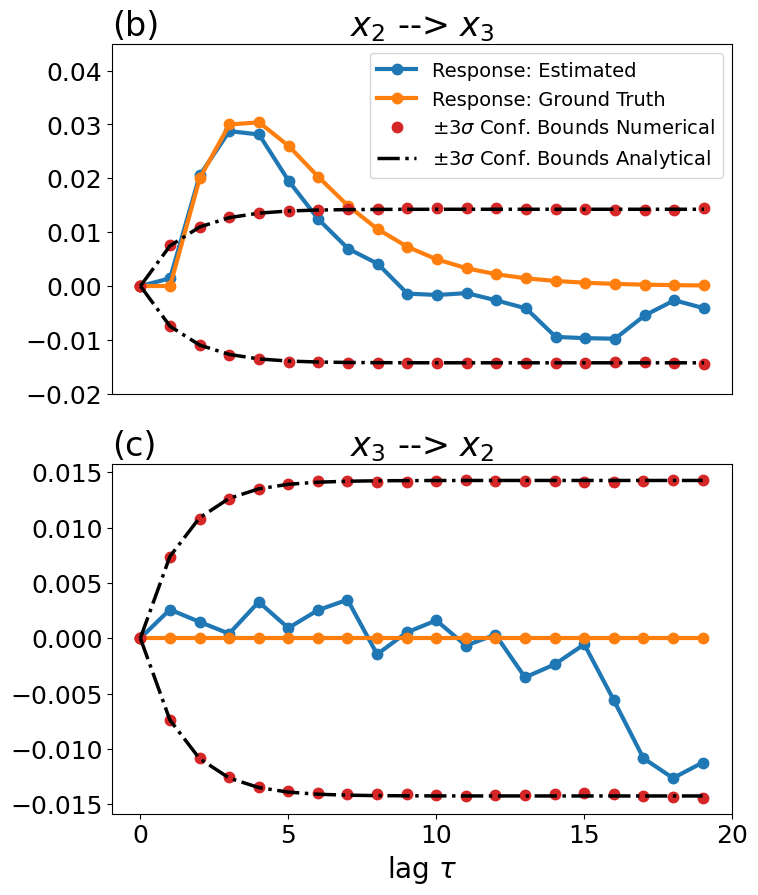

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [67]:
fig = plt.figure(figsize=(8,10))

j = 1
k = 2

ax = plt.subplot(211)
plt.plot(response_matrix_example[:,k,j],'.-',label = 'Response: Estimated',color = 'tab:blue',linewidth = 3,markersize = 15)
plt.plot(true_response[:,k,j],'.-',label = 'Response: Ground Truth',color = 'tab:orange',linewidth = 3,markersize = 15)

# R = 1000
plt.plot(plus_3_sigma[:,k,j],'.',color = 'tab:red',markersize = 15)
plt.plot(minus_3_sigma[:,k,j],'.',color = 'tab:red',label = '$\pm 3\sigma$ Conf. Bounds Numerical',markersize = 15)

# Analytical
plt.plot(analytical_plus_3_sigma[:,k,j],'-.', color = 'k',linewidth = 2.5,markersize = 20)#
plt.plot(analytical_minus_3_sigma[:,k,j],'-.',label = '$\pm 3\sigma$ Conf. Bounds Analytical',color = 'k',linewidth = 2.5,markersize = 20)

plt.legend(fontsize = 14)
plt.xticks([])
plt.yticks(fontsize = 18)
#ax.set_xticks([0,5,10,15,20])
#ax.set_xticklabels(['0','5','10','15','20'])

plt.ylim([-0.02,0.045])

#plt.xlabel('lag ' + r'$\tau$',fontsize = 20)
        
plt.title('$x_{2}$' + ' --> ' + '$x_{3}$', fontsize=24)
plt.title('(b)', loc = 'left', fontsize=24)

j = 2
k = 1

ax = plt.subplot(212)
plt.plot(response_matrix_example[:,k,j],'.-',label = 'Estimated',color = 'tab:blue',linewidth = 3,markersize = 15)
plt.plot(true_response[:,k,j],'.-',label = 'Ground Truth',color = 'tab:orange',linewidth = 3,markersize = 15)

# R = 1000
plt.plot(plus_3_sigma[:,k,j],'.',color = 'tab:red',markersize = 15)
plt.plot(minus_3_sigma[:,k,j],'.',color = 'tab:red',label = '$\pm 3\sigma$ Conf. Bounds Numerical',markersize = 15)

# Analytical
plt.plot(analytical_plus_3_sigma[:,k,j],'-.', color = 'k',linewidth = 2.5,markersize = 20)#
plt.plot(analytical_minus_3_sigma[:,k,j],'-.',label = '$\pm 3\sigma$ Conf. Bounds Analytical',color = 'k',linewidth = 2.5,markersize = 20)

#plt.legend(fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_xticks([0,5,10,15,20])
ax.set_xticklabels(['0','5','10','15','20'])

#plt.ylim([-0.015,0.05])

plt.xlabel('lag ' + r'$\tau$',fontsize = 20)
        
plt.title('$x_{3}$' + ' --> ' + '$x_{2}$', fontsize=24)
plt.title('(c)', loc = 'left', fontsize=24)

plt.show()

fig.savefig('./Figures/test_null_model.eps',bbox_inches='tight') 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


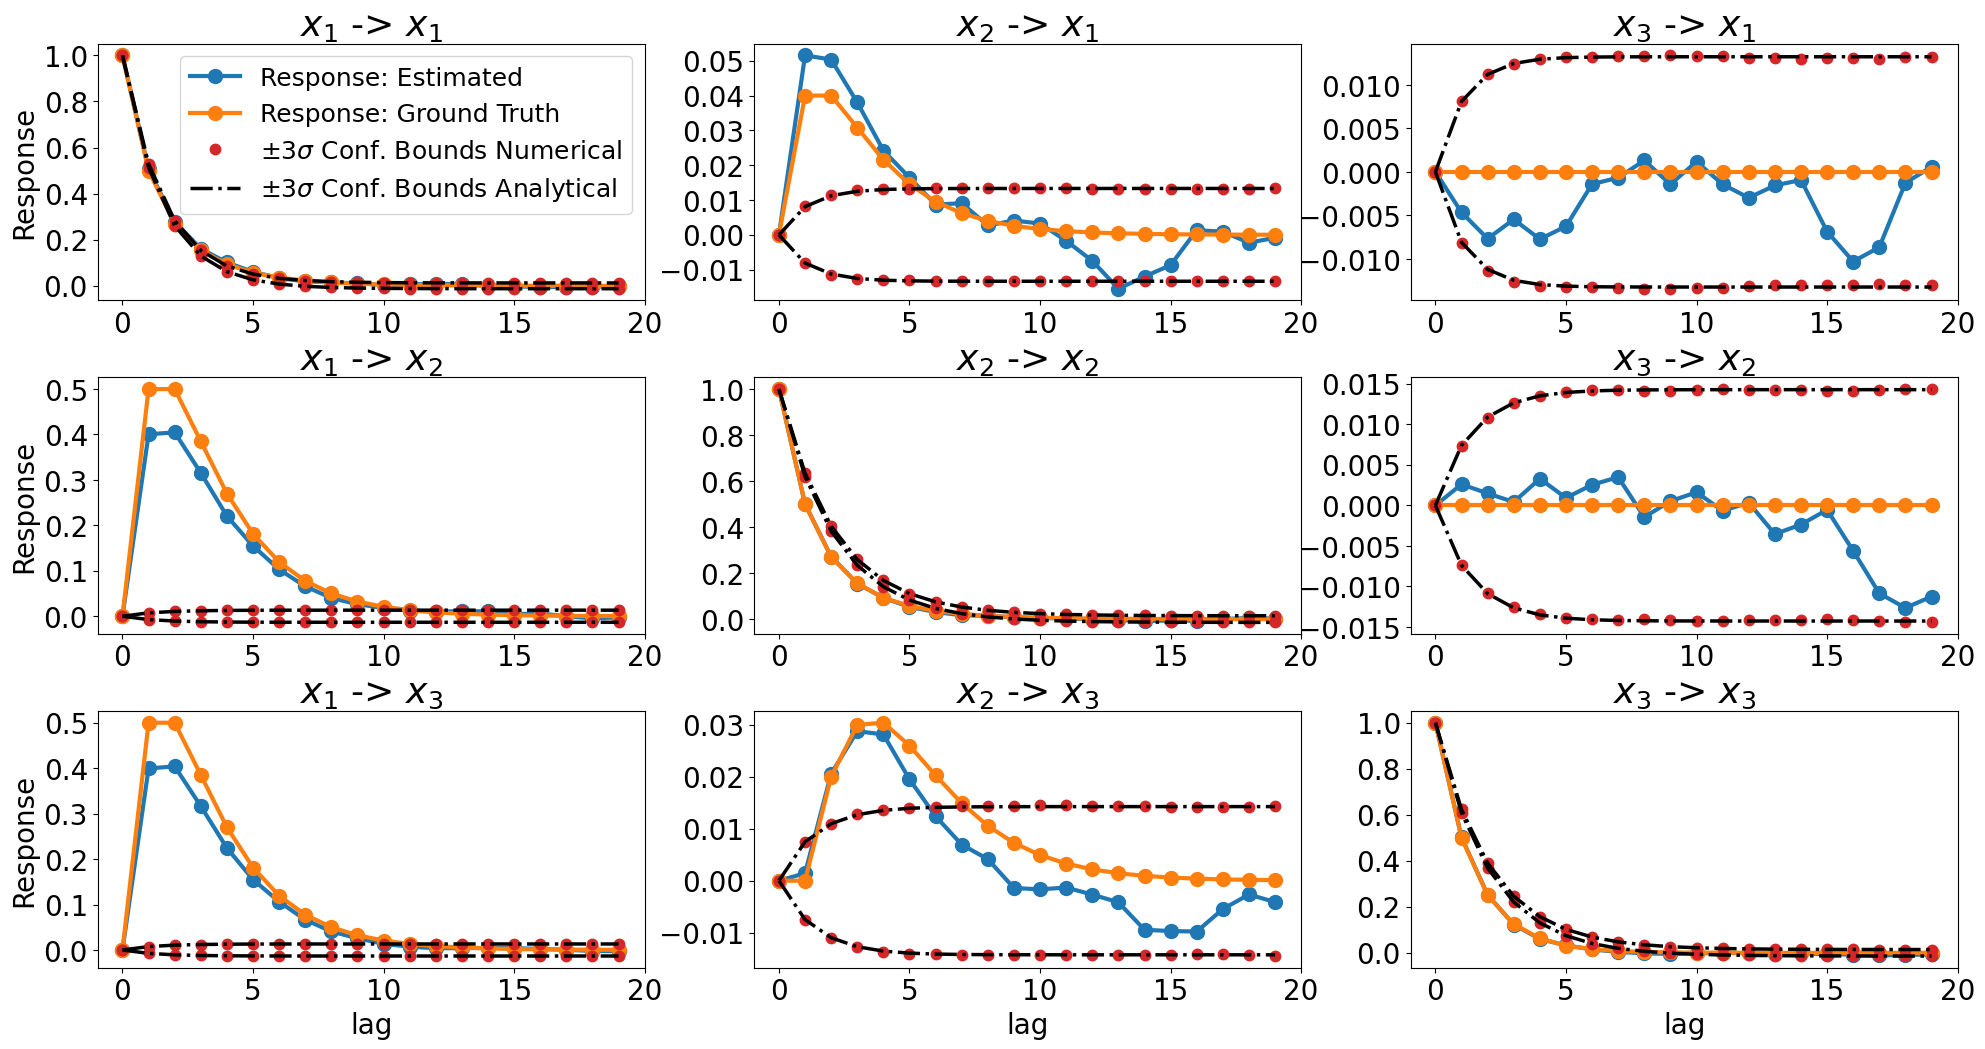

In [69]:
fig = plt.figure(figsize=(24,12))

for i in range(3):
    
    for j in range(3):
        
        if i == 0:
            subplot_idx = j + 1
        if i == 1:
            subplot_idx = j + 4
        if i == 2:
            subplot_idx = j + 7    

        ax = plt.subplot(3, 3, subplot_idx)
        
        plt.plot(response_matrix_example[:,i,j],'.-',label = 'Response: Estimated',linewidth = 3,markersize = 20)
        plt.plot(true_response[:,i,j],'.-',label = 'Response: Ground Truth',linewidth = 3,markersize = 20)
        # R = 1000
        plt.plot(plus_3_sigma[:,i,j],'.',color = 'tab:red',markersize = 15)
        plt.plot(minus_3_sigma[:,i,j],'.',color = 'tab:red',label = '$\pm 3\sigma$ Conf. Bounds Numerical',markersize = 15)

        # Analytical
        plt.plot(analytical_plus_3_sigma[:,i,j],'-.', color = 'k',linewidth = 2.5,markersize = 20)#
        plt.plot(analytical_minus_3_sigma[:,i,j],'-.',label = '$\pm 3\sigma$ Conf. Bounds Analytical',color = 'k',linewidth = 2.5,markersize = 20)

        if i == 0 and j == 0:
            plt.legend(fontsize = 18)
            
        if i == 0 and j == 0 or i == 1 and j == 0 or i == 2 and j == 0:
            plt.ylabel('Response',fontsize = 20)
            
        if i == 2 and j == 0 or i == 2 and j == 1 or i == 2 and j == 2:
            plt.xlabel('lag',fontsize = 20)  
            
        title_fontsize = 26    
            
        if i == 0 and j == 0:
            plt.title('$x_{1}$ -> $x_{1}$',fontsize = title_fontsize)
        if i == 1 and j == 1:
            plt.title('$x_{2}$ -> $x_{2}$',fontsize = title_fontsize) 
        if i == 2 and j == 2:
            plt.title('$x_{3}$ -> $x_{3}$',fontsize = title_fontsize) 
            
        if i == 0 and j == 1:
            plt.title('$x_{2}$ -> $x_{1}$',fontsize = title_fontsize)
        if i == 0 and j == 2:
            plt.title('$x_{3}$ -> $x_{1}$',fontsize = title_fontsize) 
            
        if i == 1 and j == 0:
            plt.title('$x_{1}$ -> $x_{2}$',fontsize = title_fontsize)
        if i == 1 and j == 2:
            plt.title('$x_{3}$ -> $x_{2}$',fontsize = title_fontsize)
            
        if i == 2 and j == 0:
            plt.title('$x_{1}$ -> $x_{3}$',fontsize = title_fontsize)
        if i == 2 and j == 1:
            plt.title('$x_{2}$ -> $x_{3}$',fontsize = title_fontsize)     
        
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        ax.set_xticks([0,5,10,15,20])
        ax.set_xticklabels(['0','5','10','15','20'])
        
        #plt.xlim([0,1])
        #plt.xlim([0.6,1.0])
        
        plt.subplots_adjust(wspace=0.2, hspace=0.3)
        
fig.savefig('./Figures/reponse_significance.eps',bbox_inches='tight') 

### Compute causal strength 

NOTE: there is way better ways to write this function. This was written pretty fast.

$\textit{Cumulative degree of causation}$

Given $x^{(j)} \rightarrow x^{(k)}$ we compute the "Cumulative degree of causation" as $\mathcal{D}_{j \rightarrow k} = \sum_{t = 1}^{\infty} \mid R_{t}^{k,j} \mid.$ We name this "strengths_j_k". In the paper we also use the case with no absolute value.

$\textit{Causal strength of node j}$

Given a node $x^{(j)}$ we define its "Causal strength" as $\mathcal{D}_{j} = \sum_{k} \sum_{t = 1}^{\infty} \mid R_{t}^{k,j} \mid.$ We name this "strengths_j".

Importanty, summations are made only on statistical significant values of $R$.

In [70]:
# Function to define node_strength with statistical significance
# (There are better ways to write this.)

def node_strength_significance(response_matrix,conf_bounds_plus,conf_bounds_minus):
    
    # Inputs
    # - response_matrix
    # - significance_right_tail: for example the 99th percentile of the ensemble of null models
    # - significance_left_tail: for example the 1st percentile of the ensemble of null models
    
    # Outputs:
    # - strengths_j_k: strength of the connection j -> k
    # If the original response matrix is n by n, strengths_j_k will be n x (n - 1)
    # as it will not consider self links
    
    time = np.shape(response_matrix)[0]
    # number of rows = number of columns = n
    n = np.shape(response_matrix)[1]
    
    # response_matrix_significant: assign zero if not significant
    response_matrix_significant = response_matrix.copy()
    
    # if you are not significant we change you to zero
    indices = (response_matrix < conf_bounds_plus) & (response_matrix > conf_bounds_minus)
    response_matrix_significant[indices] = 0
    
    # Strength of link j -> k
    strengths_j_k = np.zeros([n,n])
    
    # Response j -> k in absolute value
    abs_response_j_k = np.abs(response_matrix_significant[1:])
    # Compute strength of j -> k
    strengths_j_k = np.transpose(np.sum(abs_response_j_k,axis = 0))
    
    # When computing strengths we remove the j -> j connection
    # remove diagonal
    strengths_j_k_off_diagonal = strengths_j_k[~np.eye(strengths_j_k.shape[0],dtype=bool)].reshape(strengths_j_k.shape[0],-1)
    
    # Strength of node j
    strengths_j = np.sum(strengths_j_k_off_diagonal,axis = 1)
    
    return strengths_j_k, strengths_j

In [74]:
true_response = np.load('./results/true_response.npy')
response_matrix = np.load('./results/response_matrix_example.npy')
analytical_plus_3_sigma = np.load('./results/analytical_plus_3sigma.npy')
analytical_minus_3_sigma = np.load('./results/analytical_minus_3sigma.npy')

In [75]:
strengths_j_k, strengths_j = node_strength_significance(response_matrix,analytical_plus_3_sigma,analytical_minus_3_sigma)

In [79]:
strengths_j_k

array([[0.86263054, 1.74939137, 1.75186579],
       [0.19603353, 1.119771  , 0.09698871],
       [0.        , 0.        , 0.99513072]])

In [80]:
strengths_j

array([3.50125716, 0.29302223, 0.        ])

In [83]:
for j in range(3):
    for k in range(3):
        print('Strength connections of node j = '+str(j)+' ---> k = '+str(k)+ ':  ' + str(strengths_j_k[j,k]) )
    print('')    

Strength connections of node j = 0 ---> k = 0:  0.8626305425950247
Strength connections of node j = 0 ---> k = 1:  1.7493913715638088
Strength connections of node j = 0 ---> k = 2:  1.7518657860456404

Strength connections of node j = 1 ---> k = 0:  0.1960335265758487
Strength connections of node j = 1 ---> k = 1:  1.1197710036943553
Strength connections of node j = 1 ---> k = 2:  0.09698870523386442

Strength connections of node j = 2 ---> k = 0:  0.0
Strength connections of node j = 2 ---> k = 1:  0.0
Strength connections of node j = 2 ---> k = 2:  0.9951307155684302



In [84]:
for j in range(3):
    print('Causal strength of node j = '+str(j)+ ':  ' + str(strengths_j[j]))

Causal strength of node j = 0:  3.501257157609449
Causal strength of node j = 1:  0.2930222318097131
Causal strength of node j = 2:  0.0


### In practice...

In [85]:
import utils_linear_response

In [86]:
# load the time series
x_t = np.load('./results/example_orbit_10_to_5.npy')

In [87]:
# Format of the dataset should be [Number of time series, number of time samples]
np.shape(x_t)

(3, 99900)

In [91]:
### Parameters for Response

# we compute responses up to a lag tau_max
tau_max = 20
# we compute covariances
standardized = 'yes'

In [92]:
########## Compute the response matrix
response_matrix = utils_linear_response.response(x_t,tau_max,standardized)

In [93]:
########## Compute statistical significance

############################## Step (a)
# Compute the lag 1 autocorrelation

# lag-1 autocorrelation
print('Computing lag-1 autocorr')
phi = utils_linear_response.phi_vector(x_t)

############################## Step (b)
# Compute standard deviations of each time series

# sigmas
print('Computing sigmas')
sigmas = utils_linear_response.sigmas(x_t)

### Parameters

# we compute responses up to a lag tau_max
tau_max = 20
# we compute covariances
standardized = 'yes'

s = 3

# This correspondes to +/- 3 sigmas

s_minus, s_plus = utils_linear_response.compute_quantile_analytical_tau_discrete(x_t,phi,sigmas,tau_max,s,standardized='yes')

Computing lag-1 autocorr
Computing sigmas



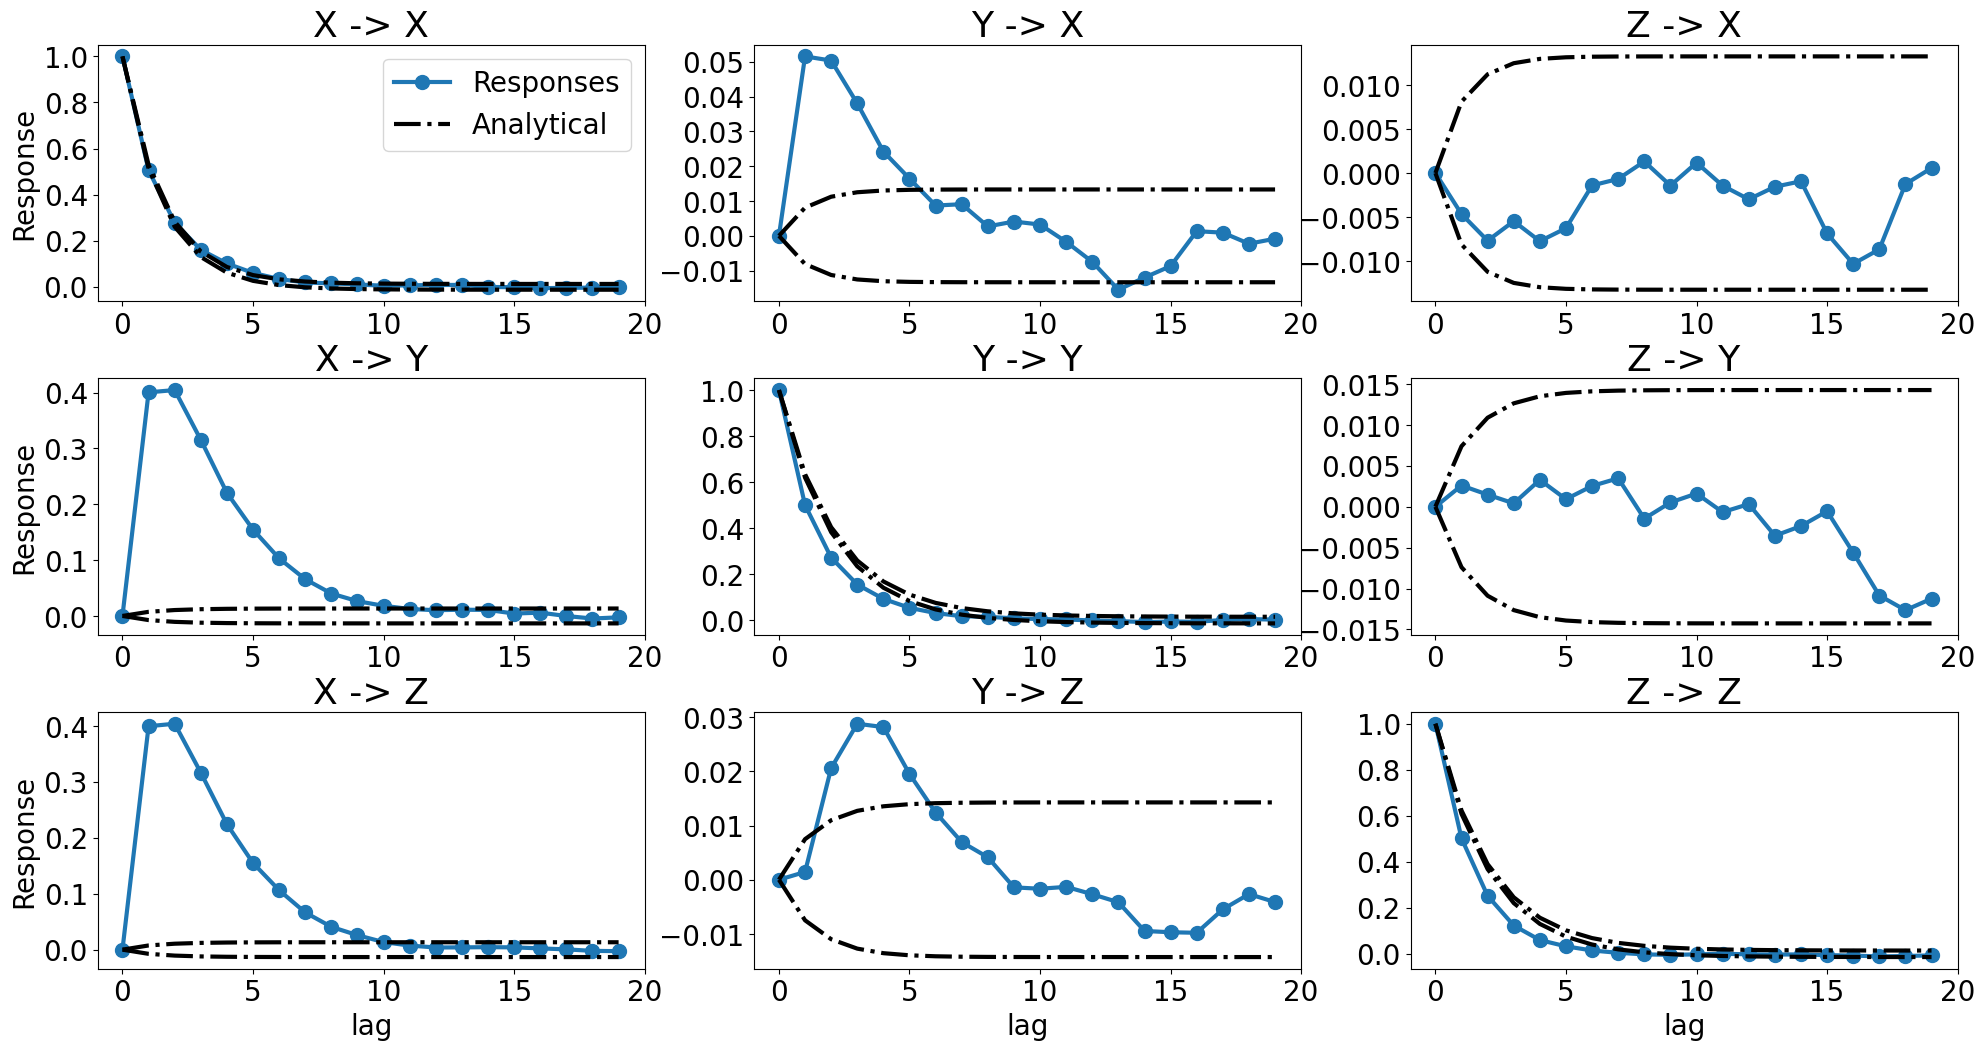

In [94]:
fig = plt.figure(figsize=(24,12))

for i in range(3):
    
    for j in range(3):
        
        if i == 0:
            subplot_idx = j + 1
        if i == 1:
            subplot_idx = j + 4
        if i == 2:
            subplot_idx = j + 7    

        ax = plt.subplot(3, 3, subplot_idx)
        
        plt.plot(response_matrix[:,i,j],'.-',label = 'Responses',linewidth = 3,markersize = 20)
        plt.plot(s_plus[:,i,j],'-.',color = 'k',linewidth = 3,markersize = 20)
        plt.plot(s_minus[:,i,j],'-.',label = 'Analytical',color = 'k',linewidth = 3,markersize = 20)
        
        if i == 0 and j == 0:
            plt.legend(fontsize = 20)
            
        if i == 0 and j == 0 or i == 1 and j == 0 or i == 2 and j == 0:
            plt.ylabel('Response',fontsize = 20)
            
        if i == 2 and j == 0 or i == 2 and j == 1 or i == 2 and j == 2:
            plt.xlabel('lag',fontsize = 20)  
            
        title_fontsize = 26    
            
        if i == 0 and j == 0:
            plt.title('X -> X',fontsize = title_fontsize)
        if i == 1 and j == 1:
            plt.title('Y -> Y',fontsize = title_fontsize) 
        if i == 2 and j == 2:
            plt.title('Z -> Z',fontsize = title_fontsize) 
            
        if i == 0 and j == 1:
            plt.title('Y -> X',fontsize = title_fontsize)
        if i == 0 and j == 2:
            plt.title('Z -> X',fontsize = title_fontsize) 
            
        if i == 1 and j == 0:
            plt.title('X -> Y',fontsize = title_fontsize)
        if i == 1 and j == 2:
            plt.title('Z -> Y',fontsize = title_fontsize)
            
        if i == 2 and j == 0:
            plt.title('X -> Z',fontsize = title_fontsize)
        if i == 2 and j == 1:
            plt.title('Y -> Z',fontsize = title_fontsize)     
        
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        ax.set_xticks([0,5,10,15,20])
        ax.set_xticklabels(['0','5','10','15','20'])
        
        #plt.xlim([0,1])
        #plt.xlim([0.6,1.0])
        
        plt.subplots_adjust(wspace=0.2, hspace=0.3)
        
#fig.savefig('./figures/reponse_ensemble_significance.eps',bbox_inches='tight') 